# Retrieve Satellite Data from Google Earth Engine

In [1]:
import ee
import json
import pandas as pd
import geopandas as gpd
from pathlib import Path
from IPython.display import display
from datetime import datetime
%matplotlib inline

## Authentication

In [2]:
from soil_roughness_change_detection.modules.authentication import authenticate
authenticate()

## Load Shapes of the Area of Interest

In [3]:
shape_file_path = Path('./data/harrysfarm/harrysfarm_fields.shp')
shape_gdf = gpd.read_file(shape_file_path.as_posix())

items = json.loads(shape_gdf.to_json())

features = []
for feature in items['features']:
    # coords = feature['geometry']['coordinates']
    aoi = ee.Geometry(feature['geometry'])
    properties = feature['properties']
    f = ee.Feature(aoi, properties)
    features.append(f)
feature_collection = ee.FeatureCollection(features)

<Axes: >

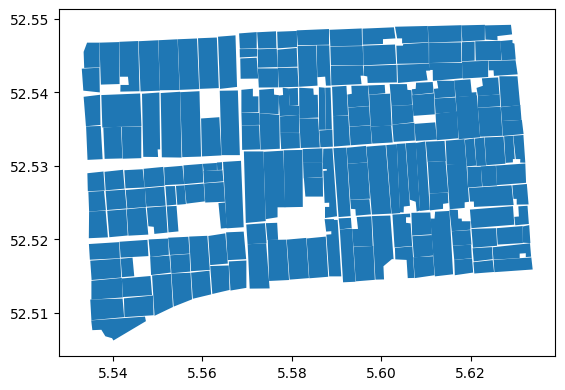

In [4]:
shape_gdf.plot()

## Config

In [5]:
from_date = '2016-12-31'
to_date = '2023-12-31'

## Load Data from Sentinel-1

In [6]:
s1_col = (
    ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
        .filterDate(from_date, to_date)
        .filterBounds(feature_collection)
)

In [7]:
def get_vv(img):
    return ee.Feature(None, {
        'date': img.date(),
        'platform': img.get('platform_number'),
        'orbit': img.get('orbitProperties_pass'),
        'fields': img.reduceRegions(
            feature_collection,
            ee.Reducer.mean()
        ).reduceColumns(ee.Reducer.toList(3), ['id', 'VV', 'VH']).values().get(0)
    })
results = s1_col.map(get_vv).reduceColumns(ee.Reducer.toList(4), ['date', 'platform', 'orbit', 'fields']).values().get(0).getInfo()

In [8]:
all_df = []
for result in results:
    date_info, platform, orbit, rows = result
    date = datetime.fromtimestamp(date_info['value'] // 1000)
    df = pd.DataFrame(rows, columns=['field_id', 'VV', 'VH'])
    df['date'] = date
    df['platform'] = platform
    df['orbit'] = 'D' if orbit == 'DESCENDING' else 'A'
    df = df.dropna()
    if df.shape[0] > 0:
        all_df.append(df)
df = pd.concat(all_df)
df['date'] = df.date.dt.date
df = df.groupby(['field_id', 'date', 'platform', 'orbit']).mean()
df = df.dropna()

In [9]:
df.to_pickle('./data/harrysfarm/harrysfarm_fields_s1.pkl')

In [10]:
df.head()

VV        VH
field_id date       platform orbit                    
0        2016-12-31 B        D      0.343375  0.034643
         2017-01-01 A        D      0.245772  0.026577
         2017-01-04 A        A      0.359664  0.039818
         2017-01-06 A        D      0.091723  0.008253
         2017-01-07 B        D      0.068319  0.005627

## Load Data from Sentinel-2

In [11]:
s2_col = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(from_date, to_date)
        .filterBounds(feature_collection)
)

In [12]:
def get_band(img):
    return ee.Feature(None, {
        'date': img.date(),
        'fields': img.reduceRegions(
            feature_collection,
            ee.Reducer.mean()
        ).reduceColumns(ee.Reducer.toList(3), ['id', 'B4', 'B5']).values().get(0)
    })
results = s2_col.map(get_band).reduceColumns(
    ee.Reducer.toList(2), ['date', 'fields']
).values().get(0).getInfo()

In [13]:
all_df = []
for result in results:
    date_info, rows = result
    date = datetime.fromtimestamp(date_info['value'] // 1000)
    df = pd.DataFrame(rows, columns=['field_id', 'B4', 'B5'])
    df['date'] = date
    df = df.dropna()
    if df.shape[0] > 0:
        all_df.append(df)
df = pd.concat(all_df)
df['date'] = df.date.dt.date
df = df.groupby(['field_id', 'date']).mean()
df = df.dropna()

df.to_pickle('./data/harrysfarm/harrysfarm_fields_ndvi.pkl')

In [14]:
df.head()

B4           B5
field_id date                                
0        2017-04-03  4772.718229  4912.699575
         2017-04-06  3641.417956  3872.867455
         2017-04-26  1183.714134  1346.952533
         2017-05-03  6944.527449  7403.833940
         2017-05-06  1657.454807  1866.963452

## Load Data from The Global Precipitation Measurement Mission (GPM)

In [15]:
rainfall = (
    ee.ImageCollection("NASA/GPM_L3/IMERG_V06")
        .filterBounds(aoi)
)

In [16]:
def get_rainfall(img):
    data = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.centroid(),
        scale=10000,  # Scale in meters
        maxPixels=1e9
    )
    return ee.Feature(
        aoi.centroid(), {
        'precipitation': data.get('precipitationCal'),
        'liquid_probability': data.get('probabilityLiquidPrecipitation')
    })
startDate = ee.Date(from_date)
endDate = ee.Date(to_date)

def compute(dayOffset):
    start = startDate.advance(dayOffset, 'days')
    end = start.advance(1, 'days')
    return ee.Feature(None, {
        'date': start.format('YYYY-MM-dd'),
        'precitipation': get_rainfall(rainfall.filterDate(start, end).mean())
    })


numberOfDays = endDate.difference(startDate, 'days')
daily = ee.List.sequence(0, numberOfDays.subtract(1)).map(compute)
results = daily.getInfo()

In [17]:
data = [{
    'date': f['properties']['date'],
    'liquid_probability': f['properties']['precitipation']['properties']['liquid_probability'],
    'precipitation': f['properties']['precitipation']['properties']['precipitation']
    } for f in results
]

agg_df = pd.DataFrame.from_records(data).groupby('date').agg({
    'liquid_probability': 'mean',
    'precipitation': 'sum'
})
agg_df['precipitation'] = agg_df['precipitation'] / 2
agg_df.index = pd.to_datetime(agg_df.index)
agg_df.to_pickle(f'./data/harrysfarm/harrysfarm_precitipation.pkl')

In [18]:
agg_df.head()

,liquid_probability,precipitation
date,,
2016-12-31,99.041667,0.003932
2017-01-01,98.625000,0.017883
2017-01-02,98.875000,0.005133
2017-01-03,99.541667,0.053182
2017-01-04,99.208333,0.025535
